<a href="https://colab.research.google.com/github/Ivan412/training/blob/main/6_python_advaced/4_reports%20and%20automation/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Продвинутый Python. Часть 4: Отчеты и автоматизация. Генерация отчетов.

---


#**Задание: многостраничный отчет**

Используя данные по активностям в парках Москвы

https://video.ittensive.com/python-advanced/data-107235-2019-12-02.utf.json

Создайте PDF отчет, в котором выведите:

1. Диаграмму распределения числа активностей по паркам, топ10 самых активных

2. Таблицу активностей по всем паркам в виде Активность-Расписание-Парк

In [1]:
%%capture
#установим wkhtmltopdf
! wget "https://github.com/wkhtmltopdf/wkhtmltopdf/releases/download/0.12.4/wkhtmltox-0.12.4_linux-generic-amd64.tar.xz" && \
  tar vxfJ "wkhtmltox-0.12.4_linux-generic-amd64.tar.xz" && \
  mv wkhtmltox/bin/wkhtmltopdf /usr/bin/wkhtmltopdf

In [2]:
%%capture
#установим pdfkit
!pip install pdfkit

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import binascii
from jinja2 import Template
import pdfkit
config = pdfkit.configuration(wkhtmltopdf="/usr/bin/wkhtmltopdf")

In [4]:
#html шаблон отчета
TEMPLATE = '''<html>
<head>
</head>
  <style>
  tr { page-break-inside: avoid; }
  </style>
  <title>Отчет по активностям в парках</title>
  <meta charset="utf-8"/>
<body>
  <h1>Распределение активностей</h1>
  <img src="{{data.image}}" alt="Распределение активностей" style="page-break-before:always;">
  <h2>Данные по активностям</h2>
  {{data.table}}
</body>
</html>'''

In [5]:
#загрузим данные, отбросим лишнее и извлечем название парка
data = pd.read_json('https://video.ittensive.com/python-advanced/data-107235-2019-12-02.utf.json')
data = data[['CoursesTimetable', 'NameOfPark', 'CourseName']]
data['NameOfPark'] = data['NameOfPark'].apply(lambda x: x['value'])

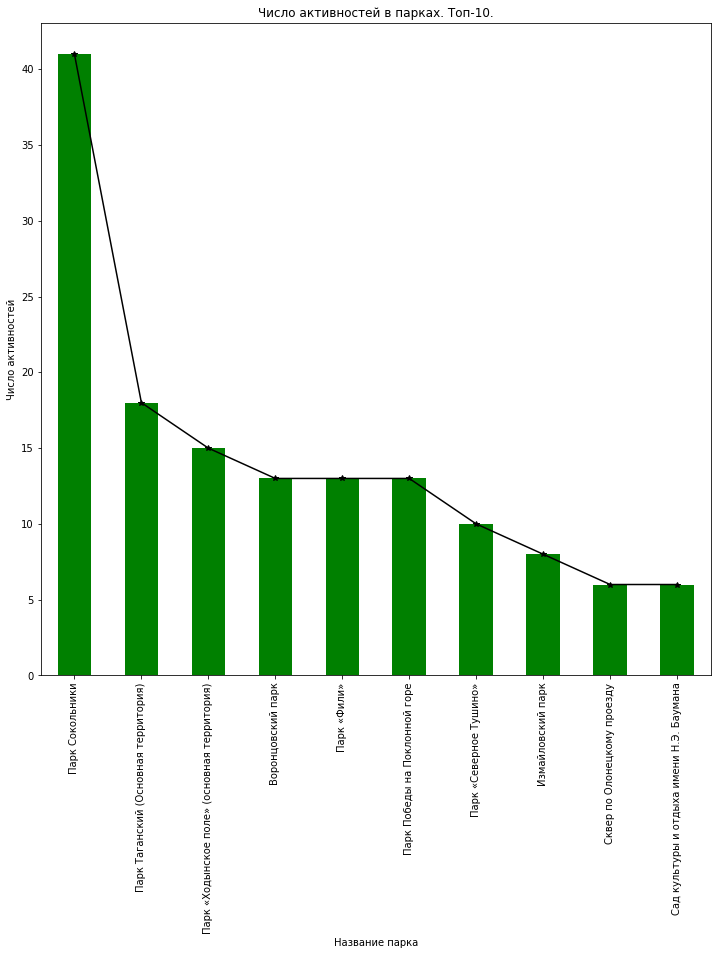

In [6]:
#создадим график активностей в парках
activities  = data[['NameOfPark', 'CourseName']].rename(columns={'NameOfPark': 'Название парка'}).groupby('Название парка').count().sort_values('CourseName', ascending=False).iloc[0:10]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Парки')
ax.set_ylabel('Число активностей')
activities['CourseName'].plot(ax=ax, kind='bar', color='green')
activities['CourseName'].plot(ax=ax, kind='line', marker='*', color='black', rot=90, title='Число активностей в парках. Топ-10.')

#сохраним картинку в ascii
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches="tight")
buf.seek(0)
img = 'data:image/png;base64,' + binascii.b2a_base64(buf.read(), newline=False).decode("UTF-8")


In [7]:
#отрендерим шаблон
data.rename(columns={'CoursesTimetable': 'Расписание', 'NameOfPark': 'Парк', 'CourseName': 'Активность'}, inplace=True)
html = Template(TEMPLATE).render(data={'image': img, 'table': data[['Активность', 'Расписание', 'Парк']].to_html()})

In [8]:
#создадим pdf
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
pdfkit.from_string(html, 'activities.pdf',
                  configuration=config, options = options)

True